# Assignment 7: Explainable Machine Learing (Part 1)

## Objective:

Interpreting how a machine learning model works is crucial from many aspects, such as debugging the model, improving the model, and derive new insights from the model. There are many model explanation techniques that we can use for interpreting a black box model itself or its predictions. Also, some models are transparent that we can directly get insights from its structure or learned parameters. In this assignment, you are going to train different models on a dataset and try different approaches to explain the model and get some insights. After completing this assignment, you should be able to answer the following questions:

1. How to explain transparent models?
2. How to implement the permutation method to explain black-box models?
3. How to create and interpret partial dependence plots?
4. How to implement the global surrogate method to explain black-box models?
5. How to use SHAP to explain model predictions and interpret its explanation results? 
6. How to use LIME to explain model predictions and  interpret its explanation results? 

The data can be downloaded from [A7-1-data.zip](A7-1-data.zip)



## 0. Preparation

Import relevant libraries and load the dataset:

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataprep.eda import plot

from sklearn.model_selection import train_test_split
from sklearn.inspection import plot_partial_dependence
from sklearn.metrics import log_loss
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

The dataset we are going to use is a binary forest covertype dataset and we will predict the forest cover type from cartographic variables only. The first ten features are numerical features, there are also two categorical features in a one-hot encoding fashion (4 and 40 vector length each), the last column is the target forest cover type (binary). More details about the dataset can be found at [https://archive.ics.uci.edu/ml/datasets/covertype](https://archive.ics.uci.edu/ml/datasets/covertype). Please make sure you understand the meaning of each feature.

In [12]:
# load data and take a look at data distribution
data = pd.read_csv('bforest_sample.csv', delimiter=',')
plot(data)

GridBox(id='7604', ...)

In [13]:
# split data into training and test dataset with respect to ratio 0.8:0.2
train, test = train_test_split(data, test_size=0.2, random_state=733)
X_train, y_train = train.iloc[:, :-1], train.iloc[:, -1]
X_test, y_test = test.iloc[:, :-1], test.iloc[:, -1]
feature_names = list(X_train)

# rescale
scaler = MinMaxScaler()
X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=feature_names)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=feature_names)


## Task 1. Transparent Model

In this task, you are going to train a logistic regression model and interpret it. For logistic regression, since the effect of each feature is simply added together, we can interpret it directly by looking at the coefficient of each feature. Please follow the comment to finish the code:

In [14]:
# train a logistic regression model
lr = LogisticRegression().fit(X_train, y_train)

C:\Users\najee\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [15]:
# set default figure size
plt.rcParams['figure.figsize'] = [16, 8]

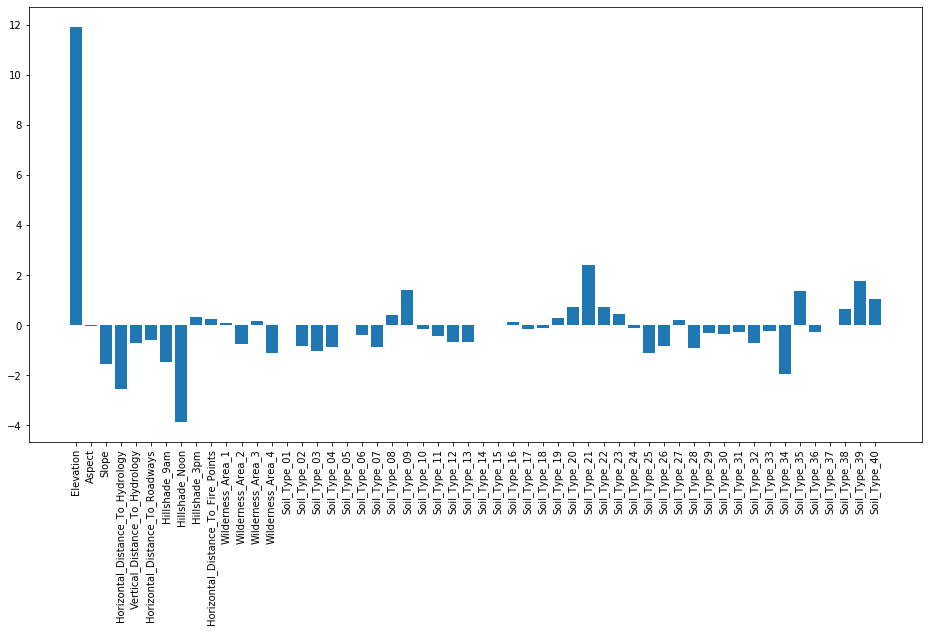

In [16]:
# show the coefficient value for each feature by a bar chart
def explain_logistic_regression(lr, feature_names):
    # --- Write your code below ---
    x = np.arange(len(feature_names))
    fig, ax = plt.subplots()
    plt.bar(x, lr.coef_[0])
    plt.xticks(x, feature_names, rotation=90)
    plt.show()

# explain the model
explain_logistic_regression(lr, feature_names)

For a specific prediction, we can get a more concrete effect of each feature by the product of the coefficient and input feature value. Please follow the comment to finish the code:

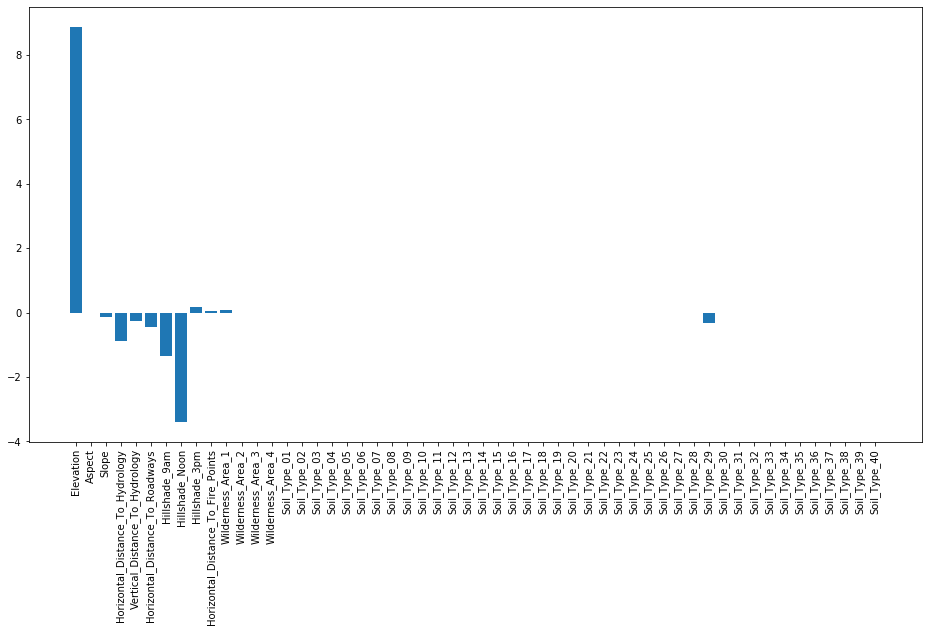

In [17]:
# show the effect from each input feature by a bar chart
def explain_logistic_regression_prediction(lr, feature_names, sample):
    # --- Write your code below ---
    new_lr = []
    for i in range(len(feature_names)):
        new_lr.append(sample[0][i]*lr.coef_[0][i])
    x = np.arange(len(feature_names))
    fig, ax = plt.subplots()
    plt.bar(x, new_lr)
    plt.xticks(x, feature_names, rotation=90)
    plt.show()
    
    
explain_logistic_regression_prediction(lr, feature_names, (X_test.iloc[0, :], y_test.iloc[0]))

What can you get from the above plots? Please write down two findings:

**Findings:**
1. From the plots above we can see that, Elevation has the highest impact on the prediction and the model
2. When we check the coefficients for a sample prediction, we can see that the all the soil types do not play a role in defining a forest cover (as given by the first plot) but a specific soil type has an effect on the forest cover type

## Task 2. Post-hoc Explanation (Global Model)

In this task, you are going to build a gradient boosting tree model and a neural network, and use some techniques we introduced in class to interpret these models. First, let's train the models using training data:

In [6]:
# train a gradient boosting classifier
gb = GradientBoostingClassifier().fit(X_train, y_train)

In [7]:
# train a multi-layer perceptron classifier
mlp = MLPClassifier(learning_rate_init=0.1).fit(X_train, y_train)

### 2.1 Permutation

In [8]:
from sklearn.utils import shuffle
import itertools

def permutation_importance(model, feature_names, X, y):
    # calculate importance score for each feature by purmutation approach
    y_predict = model.predict_proba(X)
    E = log_loss(y,y_predict)

    #predict, calculate score
    #push in a list with feature name and score
    #output top 5 least error features
    feature_impScore = dict()
    for index,feat in enumerate(feature_names):
        X_copy = X.copy()
        np.random.shuffle(X_copy[:,index])
        y_pred = model.predict_proba(X_copy)
        Eprime = log_loss(y,y_pred)
        feature_impScore[feat] = Eprime - E
    
    
    feature_impScore = sorted(feature_impScore.items(), key=lambda x: x[1], reverse=True)
    for index,val in enumerate(feature_impScore[:5]):
        print(val[0],val[1])
        if(index ==4):
            break
        
        
print("Features and Scores are:")    
permutation_importance(gb, feature_names, X_test.to_numpy(), y_test.to_numpy())
print("\n")
permutation_importance(mlp, feature_names, X_test.to_numpy(), y_test.to_numpy())

Features and Score are:
Elevation 0.36554711106333737
Horizontal_Distance_To_Roadways 0.032597265658449226
Horizontal_Distance_To_Hydrology 0.025343084818933326
Hillshade_Noon 0.019090795739478528
Horizontal_Distance_To_Fire_Points 0.016193618291407474


Elevation 0.48261684487764517
Horizontal_Distance_To_Hydrology 0.053784861819415275
Horizontal_Distance_To_Roadways 0.047188396404353905
Hillshade_Noon 0.03982479326687399
Wilderness_Area_1 0.029284781305998764


### 2.2 Partial dependence plots

In this section, you are going to use the [plot_partial_dependence](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.plot_partial_dependence.html#sklearn.inspection.plot_partial_dependence) provided by sklearn to see the marginal effect of each single numerical features:

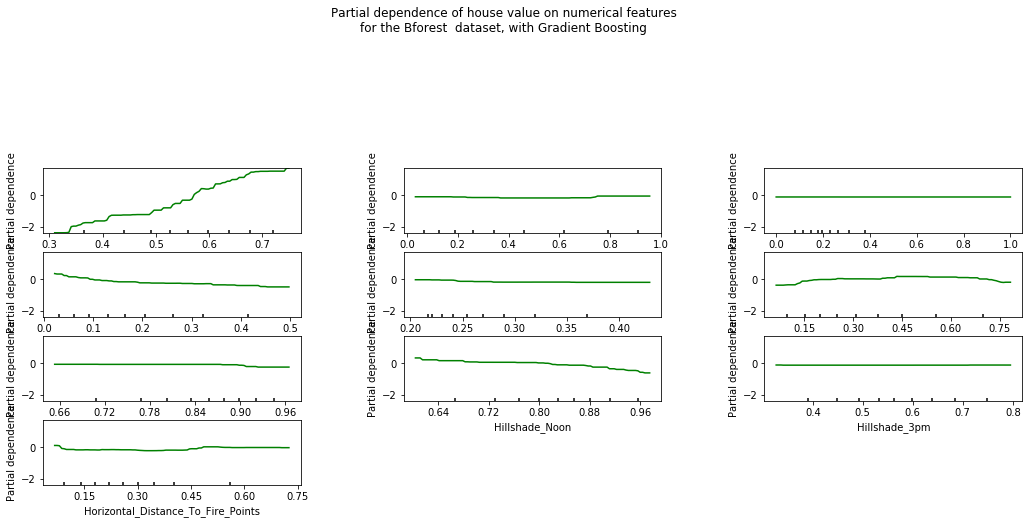

In [18]:
# plot partial dependence for numerical features (first 10 features) for gradient boosting classifier
plot_partial_dependence(gb, X_train,np.arange(10),feature_names[:10])  

fig = plt.gcf()
fig.suptitle('Partial dependence of house value on numerical features\n'
             'for the Bforest  dataset, with Gradient Boosting')
fig.subplots_adjust(hspace=0.3);

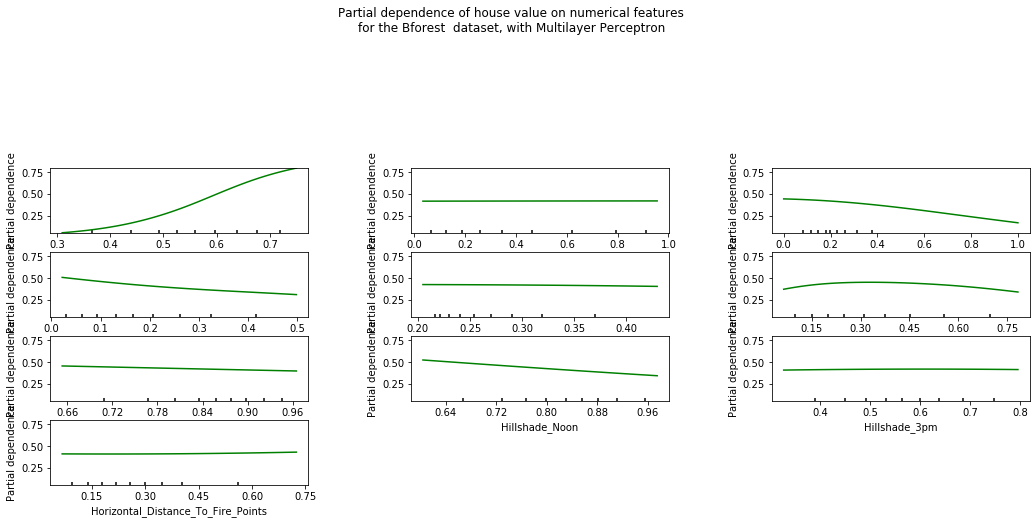

In [19]:
# plot partial dependence for numerical features (first 10 features) for neural network

plot_partial_dependence(mlp, X_train,np.arange(10),feature_names[:10])  

fig = plt.gcf()
fig.suptitle('Partial dependence of house value on numerical features\n'
             'for the Bforest  dataset, with Multilayer Perceptron')
fig.subplots_adjust(hspace=0.3);

### 2.3 Global Surrogate

Now, let's train a simple logistic regression based on the gradient boosting tree model and neural network we built before. And use the method we implemented previously to interpret the derived transparent model:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


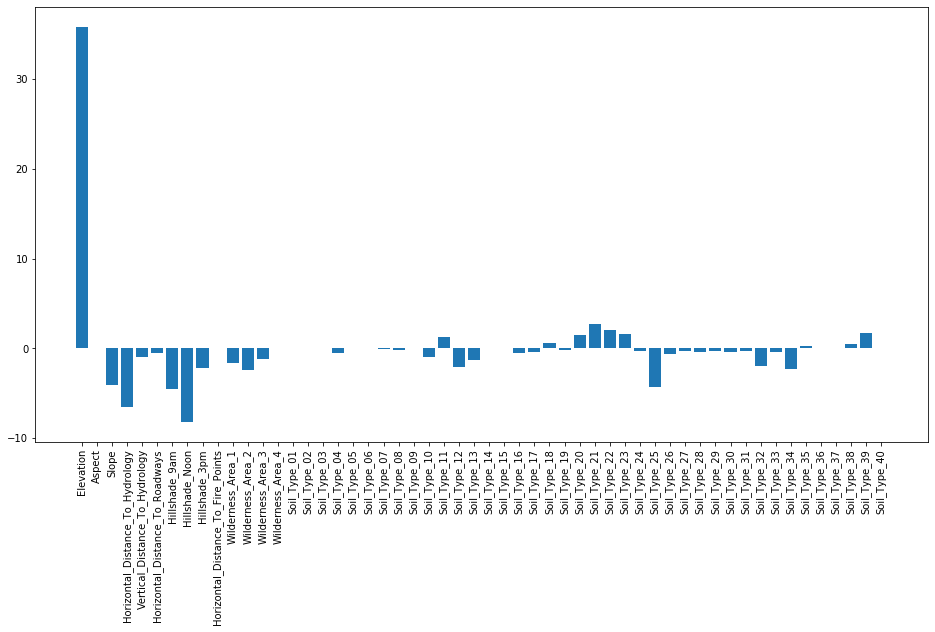

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.


<Figure size 1152x576 with 0 Axes>

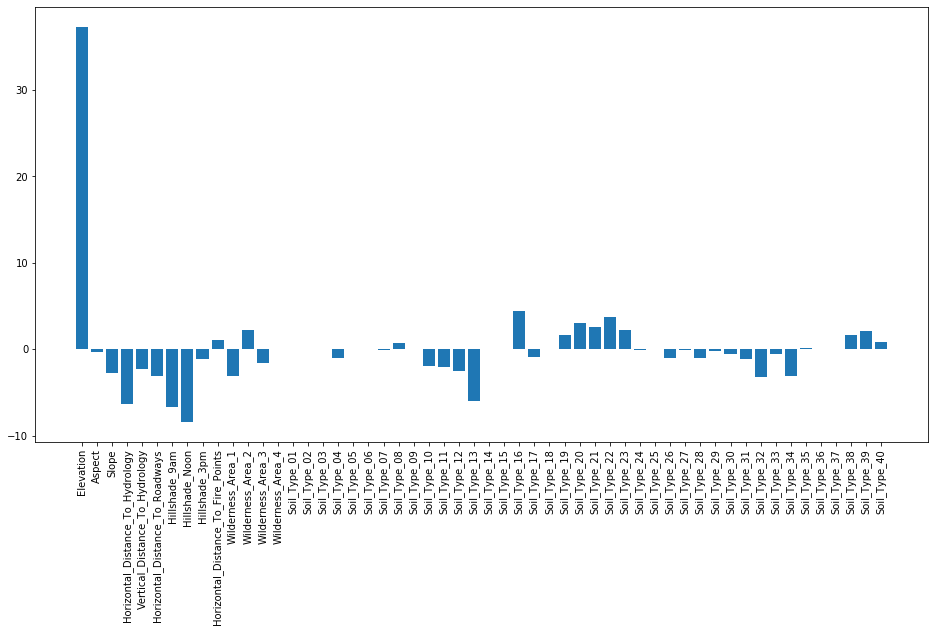

Text(0.5, 0.98, 'Surrogate Model for Multilayer Perceptron Classifier')

<Figure size 1152x576 with 0 Axes>

In [158]:

y_gb = gb.predict(X_train)
y_mlp = mlp.predict(X_train)
clf = LogisticRegression(random_state=0).fit(X_train, y_gb)
explain_logistic_regression(clf, feature_names)
fig = plt.gcf()
fig.suptitle("Surrogate Model for Gradient Boosting Classifier")
clf = LogisticRegression(random_state=0).fit(X_train, y_mlp)
explain_logistic_regression(clf, feature_names)
fig = plt.gcf()
fig.suptitle("Surrogate Model for Multilayer Perceptron Classifier")




## Task 3. Post-hoc Explanation (Single Prediction)

### 3.1 Attribution

From now, let's focus on interpreting single predictions. [SHAP](https://github.com/slundberg/shap) is an efficient method to approximatly calculate the shapely value we mentioned in class. Please install the library and take a look at the doc. Explain the first prediction made by the gradient boosting tree model in the test set:

In [115]:
import shap

# load JS visualization code to notebook
shap.initjs()

# you only need to explain and plot the first explaination


explainer = shap.TreeExplainer(gb)
shap_values = explainer.shap_values(X_test)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:])



What can you get from the above representation? Please write down two findings:

**Findings:**
1. The base value of the model for this sample is -0.4003, and the feature Elevation has the most impact on "pushing" the value higher to the output value
2. Correspondingly, features "Soil_Type_29" and "Horizontal_Distance_To_Roadways" has the an impact on "pushing" the prediction values to a lower side

### 3.2 LIME

[LIME](https://github.com/marcotcr/lime) is a library implemented by the authors of the paper. Please install the library and take a look at the doc and tutorial. Use it to explain the first prediction made by the neural network model in the test set:

In [47]:
import lime
import lime.lime_tabular

# use LimeTabularExplainer to explain the neural network model

class_names = mlp.classes_
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.to_numpy() ,feature_names = feature_names,categorical_features=[0,1])
exp = explainer.explain_instance(X_test.to_numpy()[0],mlp.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True,show_all=False)

Run LIME multiple times, (Q1) what do you think of the stability of LIME? (Q2) Can you briefly explain the reason?

**Your Answer:** 
1. LIME is not stable, the feature weights change at almost every run. But the prediction probabilities are mostly constant unless random seed is changed
2. This is due to, LIME perturbs input values and builds a simple model with the probabilites of the model on the perturbed input values. Since probabilities can differ slighlty in every run, LIME feature weights can change too

## Submission
Complete the code in this notebook, and submit it to the CourSys activity Assignment 7.